In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import folium
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import GRU, Dropout, Dense


In [2]:
# Loading the dataset
data = pd.read_csv("METR-LA.csv", parse_dates=['timestamp'], index_col='timestamp')

# Selecting the sensor data
sensor_data = data.iloc[:, 1:]

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sensor_data)

# Functioning to create input-output pairs
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Spliting the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Creating input-output pairs for train and test sets
lookback = 10
X_train, y_train = create_sequences(train_data, lookback)
X_test, y_test = create_sequences(test_data, lookback)

# Reshaping input to be 3D [samples, time steps, features] for GRU
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], sensor_data.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], sensor_data.shape[1]))


In [3]:
def build_gru_model(input_shape, gru_units=64, dropout_rate=0.2):
    model = Sequential()
    
    # Adding the first GRU layer with dropout
    model.add(GRU(gru_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Adding more GRU layers with dropout if needed
    model.add(GRU(gru_units, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Adding the final GRU layer without return_sequences
    model.add(GRU(gru_units))
    model.add(Dropout(dropout_rate))
    
    # Adding the output layer
    model.add(Dense(input_shape[1]))

    return model


In [4]:
# Geting the input shape from the training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Building the GRU model
model = build_gru_model(input_shape)

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [5]:
batch_size = 10
epochs = 50
validation_split = 0.2

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    shuffle=False
)

Epoch 1/50
2193/2193 [==============================] - 22s 9ms/step - loss: 0.0511 - val_loss: 0.0505
Epoch 2/50
2193/2193 [==============================] - 19s 8ms/step - loss: 0.0340 - val_loss: 0.0488
Epoch 3/50
2193/2193 [==============================] - 19s 9ms/step - loss: 0.0315 - val_loss: 0.0463
Epoch 4/50
2193/2193 [==============================] - 19s 9ms/step - loss: 0.0297 - val_loss: 0.0462
Epoch 5/50
2193/2193 [==============================] - 18s 8ms/step - loss: 0.0282 - val_loss: 0.0432
Epoch 6/50
2193/2193 [==============================] - 19s 9ms/step - loss: 0.0272 - val_loss: 0.0458
Epoch 7/50
2193/2193 [==============================] - 19s 9ms/step - loss: 0.0270 - val_loss: 0.0414
Epoch 8/50
2193/2193 [==============================] - 19s 8ms/step - loss: 0.0264 - val_loss: 0.0417
Epoch 9/50
2193/2193 [==============================] - 19s 9ms/step - loss: 0.0261 - val_loss: 0.0404
Epoch 10/50
2193/2193 [==============================] - 19s 9ms/step - l

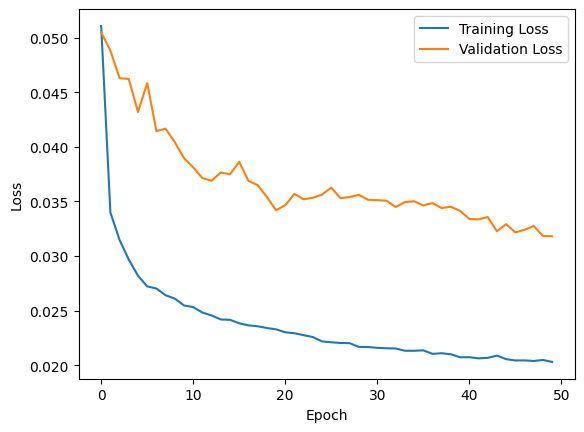

In [26]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss (MSE): {test_loss}")
y_pred = model.predict(X_test)

214/214 [==============================] - 1s 4ms/step - loss: 0.0335
Test loss (MSE): 0.03353617340326309
214/214 [==============================] - 1s 4ms/step


In [7]:


# Rescale the predicted and true values back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate MAE, RMSE, and R-squared
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 7.0877556733884575
Root Mean Squared Error (RMSE): 12.80956114291193
R-squared: 0.6611697321339268


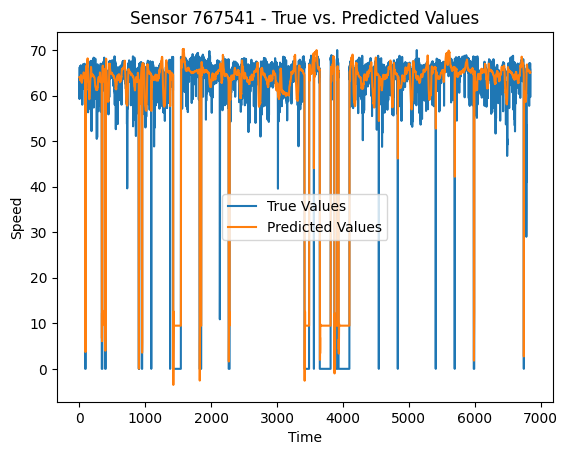

In [22]:
# Choose a specific sensor ID (e.g., '773869')
sensor_id = '767541'

# Find the index of the sensor ID in the dataset
sensor_index = list(data.columns).index(sensor_id) - 1  # Subtract 1 to account for the timestamp column

# Plot true vs. predicted values for the specific sensor
plt.plot(y_test_rescaled[:, sensor_index], label='True Values')
plt.plot(y_pred_rescaled[:, sensor_index], label='Predicted Values')
plt.title(f'Sensor {sensor_id} - True vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.show()

In [9]:
n = 100  # Number of future time steps to predict
input_sequence = X_test[-1]  # Use the last sequence in the test data as the input

future_predictions = []

for i in range(n):
    prediction = model.predict(input_sequence[np.newaxis, :, :])
    future_predictions.append(prediction[0])

    # Update the input_sequence with the new prediction
    input_sequence[:-1] = input_sequence[1:]
    input_sequence[-1] = prediction

# Rescale the future predictions back to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)


1/1 [==============================] - 0s 17ms/step


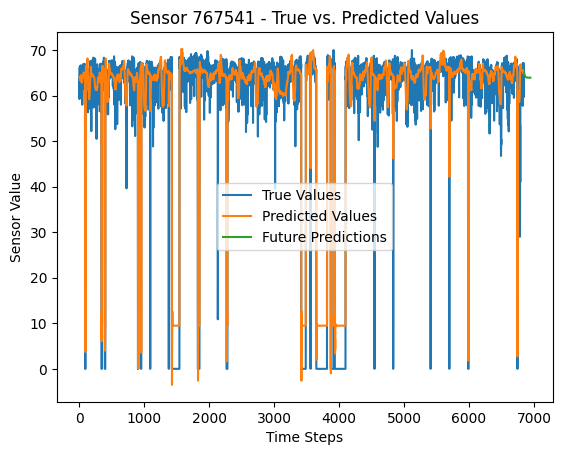

In [23]:
# Choose a specific sensor ID (e.g., '773869')
sensor_id = '767541'

# Find the index of the sensor ID in the dataset
sensor_index = list(data.columns).index(sensor_id) - 1  # Subtract 1 to account for the timestamp column

# Rescale the test data and predictions to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot the true values and predicted values for the sensor
plt.plot(y_test_rescaled[:, sensor_index], label='True Values')
plt.plot(y_pred_rescaled[:, sensor_index], label='Predicted Values')

# If you want to visualize the future predictions
if 'future_predictions_rescaled' in locals():
    prediction_start = len(y_test_rescaled)
    prediction_end = prediction_start + len(future_predictions_rescaled)
    prediction_range = range(prediction_start, prediction_end)
    plt.plot(prediction_range, future_predictions_rescaled[:, sensor_index], label='Future Predictions')

plt.xlabel('Time Steps')
plt.ylabel('Sensor Value')
plt.title(f'Sensor {sensor_id} - True vs. Predicted Values')
plt.legend()
plt.show()


In [12]:
# Reading dataset
df = pd.read_csv("METR-LA.csv")

# Converting timestamp to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index
df = df.set_index('timestamp')
train_ratio = 0.8
train_size = int(len(df) * train_ratio)
test_df = df[train_size:]

In [13]:
no_threshold=0
low_threshold = 30
medium_threshold = 50
given_time_index = 50  # Replace this with the desired index from the test dataset
traffic_speeds = test_df.iloc[given_time_index].values

In [14]:
def classify_traffic(sensor_ids, speeds, low_threshold, medium_threshold, no_threshold):
    traffic_levels = {}

    for sensor_id, speed in zip(sensor_ids, speeds):
        if speed == no_threshold:
            traffic_levels[sensor_id] = "no Traffic"
        elif speed >= medium_threshold:
            traffic_levels[sensor_id] = "Low"
        elif speed <= medium_threshold and speed >= low_threshold:
            traffic_levels[sensor_id] = "Medium"
        else:
            traffic_levels[sensor_id] = "High"

    return traffic_levels

In [15]:
traffic_levels = classify_traffic(test_df.columns, traffic_speeds, low_threshold, medium_threshold, no_threshold)

print("Low Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "Low"])

print("\nNo Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "no Traffic"])

print("\nMedium Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "Medium"])

print("\nHigh Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "High"])


Low Traffic Sensors:
['773869', '767541', '767542', '717447', '717445', '773062', '767620', '737529', '767471', '773906', '769953', '769402', '769819', '717578', '717804', '767572', '767573', '773013', '764424', '717819', '769941', '760987', '718204', '769418', '773927', '774012', '774011', '767609', '769831', '773953', '767470', '764949', '767366', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '717497', '717491', '717492', '765176', '717498', '718066', '765164', '769431', '717610', '767621', '772596', '767351', '716571', '767585', '773024', '717483', '717480', '764120', '717818', '718076', '718072', '767455', '767454', '761599', '773916', '716968', '769467', '717573', '717572', '717571', '717570', '764760', '769847', '767523', '769867', '717473', '759591', '764781', '765099', '762329', '767509', '769358', '772513', '718496', '773904', '718499', '761003', '717502', '759602', '763995', '773996', '773995', '717469', '764106', '717465', '764794', '717460', '717463'

In [25]:
future_time_index = 5  # Replace this with the desired index from the future_predictions
future_traffic_speeds = future_predictions_rescaled [future_time_index]
future_traffic_speeds = np.append(future_traffic_speeds,55.6697059)

In [24]:
future_traffic_levels = classify_traffic(test_df.columns, future_traffic_speeds, low_threshold, medium_threshold, no_threshold)
future_traffic_levels['769373']='Low'
print("Low Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "Low"])

print("\nNo Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "no Traffic"])

print("\nMedium Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "Medium"])

print("\nHigh Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "High"])


Low Traffic Sensors:
['773869', '767541', '767542', '717447', '717446', '717445', '773062', '767620', '737529', '717816', '765604', '767471', '716339', '773906', '765273', '771667', '716337', '769953', '769402', '769403', '769405', '716941', '717578', '716960', '717804', '767572', '773012', '773013', '764424', '769388', '716328', '717819', '760987', '769418', '768066', '772140', '773927', '760024', '774012', '774011', '767609', '760650', '716956', '769831', '761604', '717495', '716554', '773953', '716955', '764949', '773954', '767366', '769444', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '764766', '717497', '717490', '717491', '717492', '717493', '765176', '717498', '717499', '765171', '718064', '718066', '765164', '769431', '769430', '717610', '767053', '767621', '772596', '772597', '767350', '767351', '716571', '773023', '767585', '773024', '717483', '718379', '717481', '717480', '717486', '764120', '772151', '718371', '717489', '717488', '717818', '718076'

In [18]:
def plot_sensor_positions_on_map(sensor_positions, traffic_levels):
    # Create a map centered at the average latitude and longitude of the sensors
    avg_lat = sensor_positions["latitude"].mean()
    avg_lon = sensor_positions["longitude"].mean()
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

    # Define colors for different traffic levels
    colors = {
        "no Traffic": "gray",
        "Low": "green",
        "Medium": "orange",
        "High": "red",
    }

    # Add markers for each sensor
    for idx, row in sensor_positions.iterrows():
        sensor_id = row["sensor_id"]
        lat = row["latitude"]
        lon = row["longitude"]
        level = traffic_levels[sensor_id]
        color = colors[level]

        folium.Marker(
            location=[lat, lon],
            icon=folium.Icon(color=color),
            tooltip=f"Sensor ID: {sensor_id}, Traffic: {level}",
        ).add_to(m)

    return m


In [19]:
# Read sensor positions from the file
sensor_positions = pd.read_csv("graph_sensor_locations.csv")

# Map sensor IDs to their index in the dataset
sensor_id_to_index = {sensor_id: idx for idx, sensor_id in enumerate(sensor_positions["sensor_id"])}



# Classify traffic levels for the given time index
traffic_levels_given_time = classify_traffic(
    sensor_positions["sensor_id"],
    traffic_speeds,
    low_threshold,
    medium_threshold,
    no_threshold,
)

# Plot the sensor positions with their traffic classification on a map
m = plot_sensor_positions_on_map(sensor_positions, traffic_levels_given_time)
m.save("sensor_positions_map.html")  # Save the map as an HTML file
m  # Display the map in the notebook


In [20]:
# Read sensor positions from the file
sensor_positions = pd.read_csv("graph_sensor_locations.csv")

# Map sensor IDs to their index in the dataset
sensor_id_to_index = {sensor_id: idx for idx, sensor_id in enumerate(sensor_positions["sensor_id"])}



# Classify traffic levels for the given time index
traffic_levels_given_time = classify_traffic(
    sensor_positions["sensor_id"],
    future_traffic_speeds,
    low_threshold,
    medium_threshold,
    no_threshold,
)

# Plot the sensor positions with their traffic classification on a map
m = plot_sensor_positions_on_map(sensor_positions, traffic_levels_given_time)
m.save("sensor_positions_map.html")  # Save the map as an HTML file
m  # Display the map in the notebook
